In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("course_lead_scoring.csv")

Data preparation <br>
Check if the missing values are presented in the features.<br>
If there are missing values:<br>
For caterogiral features, replace them with 'NA'<br>
For numerical features, replace with with 0.0<br>
Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [2]:
df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [3]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [4]:
col_cat = list(df.dtypes[df.dtypes == 'object'].index)
for c in col_cat:
    df[c] = df[c].fillna('NA')

num_cat = list(df.dtypes[df.dtypes != 'object'].index)
for n in num_cat:
    df[n] = df[n].fillna(0.0)

In [5]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state=1)

In [7]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [8]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

## Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

lead_score <br>
number_of_courses_viewed <br>
interaction_count <br>
annual_income

In [9]:
from sklearn.metrics import roc_auc_score

In [10]:
roc_auc_score(y_train, df_train['lead_score'])

0.6144993577250176

In [11]:
roc_auc_score(y_train, df_train['number_of_courses_viewed'])

0.7635680590007088

In [12]:
roc_auc_score(y_train, df_train['interaction_count'])

0.738270176293409

In [13]:
roc_auc_score(y_train, df_train['annual_income'])

0.5519578313253012

In [72]:
# Ans: number_of_courses_viewed

## Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

0.32 <br>
0.52 <br>
0.72 <br>
0.92

In [56]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer()

train_dict = df_train.drop(columns=['converted']).to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val.drop(columns=['converted']).to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

roc_auc_score(y_val, y_pred)

0.8171316268814112

In [71]:
# Ans: 0.72

## Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

0.145 <br>
0.345 <br>
0.545 <br>
0.745

In [65]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    scores.append((t, p, r))

/tmp/ipykernel_5024/1673940052.py:18: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


In [66]:
columns = ['threshold','p','r']
df_scores = pd.DataFrame(scores, columns=columns)

In [68]:
import matplotlib.pyplot as plt

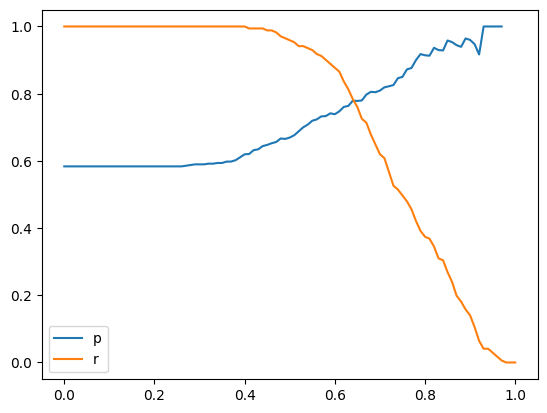

In [69]:
plt.plot(df_scores.threshold, df_scores['p'], label='p')
plt.plot(df_scores.threshold, df_scores['r'], label='r')
plt.legend()

In [70]:
# Ans: 0.745

## Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

0.14 <br> 
0.34 <br>
0.54 <br>
0.74

In [74]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    F1 = 2 * ((p * r )/ (p + r))
    
    scores.append((t, F1))

/tmp/ipykernel_5024/3825068341.py:18: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


In [75]:
columns = ['threshold','F1']
df_f1_scores = pd.DataFrame(scores, columns=columns)

In [79]:
df_f1_scores[df_f1_scores['F1']==df_f1_scores['F1'].max()]['threshold']

57    0.57
Name: threshold, dtype: float64

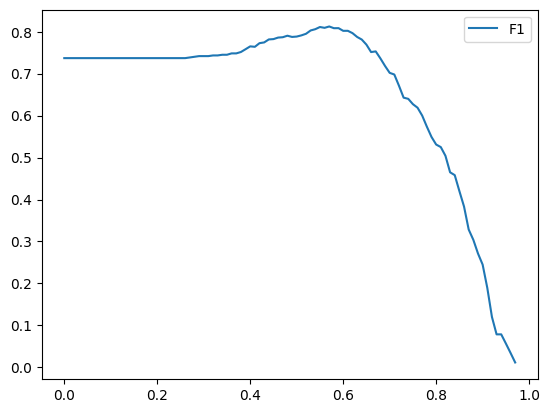

In [76]:
plt.plot(df_scores.threshold, df_f1_scores['F1'], label='F1')
plt.legend()

In [80]:
# Ans: 0.54

## Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard deviation of the scores across different folds?

0.0001 <br>
0.006 <br>
0.06 <br>
0.36 <br>

In [81]:
from sklearn.model_selection import KFold


kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kf.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val   = df_full_train.iloc[val_idx]

    y_train = df_train['converted'].values
    y_val   = df_val['converted'].values

    dv = DictVectorizer()
    X_train = dv.fit_transform(df_train.drop(columns=['converted']).to_dict('records'))
    X_val   = dv.transform(df_val.drop(columns=['converted']).to_dict('records'))

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    pos = list(model.classes_).index(1) if 1 in model.classes_ else 1
    y_pred = model.predict_proba(X_val)[:, pos]
    scores.append(roc_auc_score(y_val, y_pred))

std = np.std(scores)
print(round(std, 3))


0.036


In [ ]:
# Ans: 0.036

## Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.000001, 0.001, 1]
Initialize KFold with the same parameters as previously
Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

0.000001 <br>
0.001 <br>
1 <br>
If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [82]:
C_values = [0.000001, 0.001, 1]
kf = KFold(n_splits=5, shuffle=True, random_state=1)

for C in C_values:
    scores = []
    for train_idx, val_idx in kf.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val   = df_full_train.iloc[val_idx]

        y_train = df_train['converted'].values
        y_val   = df_val['converted'].values

        dv = DictVectorizer()
        X_train = dv.fit_transform(df_train.drop(columns=['converted']).to_dict('records'))
        X_val   = dv.transform(df_val.drop(columns=['converted']).to_dict('records'))

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        pos = list(model.classes_).index(1)
        y_pred = model.predict_proba(X_val)[:, pos]
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(f"C={C}: mean={np.mean(scores):.3f}, std={np.std(scores):.3f}")


C=1e-06: mean=0.560, std=0.024
C=0.001: mean=0.867, std=0.029
C=1: mean=0.822, std=0.036


In [83]:
# best mean score is the one with the highest mean. which is 0.001 with a mean of 0.867